In [64]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import Category10
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm.csv", index_col=0, usecols=["gene", "BB9", "BB10", "BB17",
                                                                              "BB19", "BB20", "BB21",
                                                                              "BB11", "BB12", "BB18"])
print("Tamanho dos dados:", datos.shape)
datos.head()

Tamanho dos dados: (4293, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,45.6132,57.7381,35.4817,71.4413,75.5846,59.6099,93.7032,78.2685,75.4577
aaeB,48.4527,42.2968,41.1391,44.0555,47.6292,51.5953,56.3065,69.1718,58.5695
aaeR,49.0572,53.1486,33.4681,55.6848,43.8708,64.5169,51.3741,77.9266,79043.0000
aaeX,66.7322,64.9632,64.3814,81.0705,52586.0000,69.0053,64.9201,69.2443,56966.0000
aas,73.7846,77.6379,77.6300,65.1203,64.7268,77.6184,77.5343,95.9067,93.9019


In [3]:
datos = np.log2(datos+1)

In [4]:
q25 = np.quantile(datos, .25, interpolation="midpoint", axis=0)
q50 = np.quantile(datos, .5, interpolation="midpoint", axis=0)
q75 = np.quantile(datos, .75, interpolation="midpoint", axis=0)

upper = q75 + 1.5*(q75-q25)
lower = q25 - 1.5*(q75-q25)

In [5]:
reset_output()
output_notebook()
ticks = ["0a", "0b", "0c", "30a", "30b", "30c","90a", "90b", "90c"]
p = figure(tools="", background_fill_color="#ffffff",x_range=ticks, toolbar_location=None,
          plot_height=240)
colors = Category10[3]
for i in range(0,3):
    p.vbar(ticks[i*3:(i*3)+3], width=.7, top=q75[i*3:(i*3)+3], bottom=q25[i*3:(i*3)+3],
           fill_color=colors[i], line_color="black")
    p.rect(ticks[i*3:(i*3)+3], q50[i*3:(i*3)+3], .7, .01, line_color="black", fill_color="black")
    p.segment(ticks[i*3:(i*3)+3], lower[i*3:(i*3)+3], ticks[i*3:(i*3)+3], q25[i*3:(i*3)+3],line_color="black")
    p.segment(ticks[i*3:(i*3)+3], q75[i*3:(i*3)+3], ticks[i*3:(i*3)+3], upper[i*3:(i*3)+3],line_color="black")
    p.rect(ticks[i*3:(i*3)+3], lower[i*3:(i*3)+3], .7, .01, line_color="black")
    p.rect(ticks[i*3:(i*3)+3], upper[i*3:(i*3)+3], .7, .01, line_color="black")

p.xaxis.axis_label="times"
p.yaxis.axis_label="log2(x + 1)"

Loading BokehJS ...

In [6]:
show(p)

In [7]:
rg = open("./data/reference_genes.txt", "r", newline="\n")
hkg = [i for i in rg.read().splitlines()]
print("Quantidade de genes housekeeping:", len(hkg))
print("-----------------------------------------------")
print(hkg)

Quantidade de genes housekeeping: 21
-----------------------------------------------
['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [8]:
X_train = datos.loc[hkg].dropna()
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
idnT,6.061372,6.093678,6.077117,6.325967,6.015319,6.587866,6.507484,16.668359,16.724794
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799


In [9]:
d_cv = dict()
for idx, val in X_train.iterrows():
    d_cv[idx] = np.std(val)/np.mean(val)

In [10]:
cv_values = [i for i in d_cv.values()]
q25 = np.quantile(cv_values, q=.25)
q75 = np.quantile(cv_values, q=.75)
upper_hkg = q75 + 1.5*(q75 - q25)

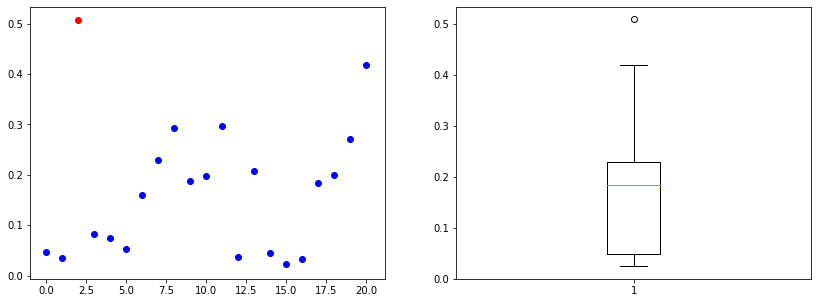

In [11]:
plt.figure(figsize=(14,5))
i = 0
plt.subplot(1,2,1)
for key in d_cv:
    if d_cv[key] <= upper_hkg:
        plt.scatter(i, d_cv[key], color="blue");
    else:
        plt.scatter(i, d_cv[key], color="red");
    i += 1
plt.subplot(1,2,2)
a = plt.boxplot(d_cv.values());

In [12]:
print("max cv: ", upper_hkg)
print("------------ outliers -------------")
for key, val in d_cv.items():
    if val >= upper_hkg:
        print(key, val)

max cv:  0.5005366248219769
------------ outliers -------------
idnT 0.5082800362135752


### data scaling

In [13]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-0.999813,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959389,-1.000000,-1.000000,-1.000000,-1.000000
idnT,-0.946080,-0.948025,-0.944276,-0.914840,-1.000000,-0.930703,-0.942743,0.562604,0.575625
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.154926,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044301,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266177,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265186,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985678,0.886011,-0.662111,0.593895,0.772322


### One-classification

In [127]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(250, input_shape=(self.noise_input,)))
        model.add(Dense(250))
        model.add(Dense(230))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [128]:
noise_input = 18
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  18


In [129]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0],noise_input))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (21, 18)
Dimension de los ejemplos generados: (21, 9)


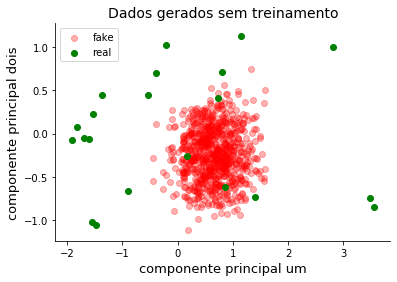

In [130]:
noise = np.random.normal(loc=0, scale=1, size=(800,noise_input))
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_fake_pca = pca_real.transform(x_noise)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="fake", alpha=.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1)
plt.legend();

In [131]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [132]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

In [133]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [134]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [135]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    fscore = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_real = X_train.loc[np.random.choice(X_train.index.values, size=12, replace=False)]
        X_fake = G.predict(np.random.normal(0, 1, (12, noise_input)))
        X_test = np.concatenate((X_real, X_fake))
        y_test = np.concatenate((np.ones((12,1)), np.zeros((12,1))))
        y_predict = D.predict_classes(X_test)
        fscore.append(f1_score(y_test, y_predict))
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
    return g_loss, d_loss, fscore

In [137]:
noise_input = 7
#Gerador
#optimizerG = Adam(lr=0.0001, beta_1=0.4)
optimizerG = SGD(lr=0.0001, momentum=0.9, decay=0.0001/1700)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
#optimizerD = Adam(lr=0.002, beta_1=0.9)
optimizerD = SGD(lr=0.02, momentum=0.85, decay=0.02/1700)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  7
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 9)                 124559    
_________________________________________________________________
sequential_31 (Sequential)   (None, 1)                 353       
Total params: 124,912
Trainable params: 124,559
Non-trainable params: 353
_________________________________________________________________


In [138]:
ep = 1700
g_loss, d_loss, fscore = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.695000],[Generator::loss: 0.690338], 3.361427[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.693149],[Generator::loss: 0.687866], 0.014204[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.668709],[Generator::loss: 0.692881], 0.014226[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.690035],[Generator::loss: 0.698566], 0.013974[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.683321],[Generator::loss: 0.701926], 0.014190[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.689253],[Generator::loss: 0.701276], 0.014168[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.674769],[Generator::loss: 0.690194], 0.013995[sec]
epoch:[8/1700] [Discriminator::d_loss: 0.653932],[Generator::loss: 0.703245], 0.014380[sec]
epoch:[9/1700] [Discriminator::d_loss: 0.689648],[Generator::loss: 0.702266], 0.014071[sec]
epoch:[10/1700] [Discriminator::d_loss: 0.653197],[Generator::loss: 0.670753], 0.014457[sec]
epoch:[11/1700] [Discriminator::d_loss: 0.661375],[Generator::loss: 0.688278], 

epoch:[98/1700] [Discriminator::d_loss: 0.449594],[Generator::loss: 1.022704], 0.015865[sec]
epoch:[99/1700] [Discriminator::d_loss: 0.442326],[Generator::loss: 1.013841], 0.015893[sec]
epoch:[100/1700] [Discriminator::d_loss: 0.406930],[Generator::loss: 1.109533], 0.025707[sec]
epoch:[101/1700] [Discriminator::d_loss: 0.438774],[Generator::loss: 1.074209], 0.016108[sec]
epoch:[102/1700] [Discriminator::d_loss: 0.461239],[Generator::loss: 1.056268], 0.015503[sec]
epoch:[103/1700] [Discriminator::d_loss: 0.435360],[Generator::loss: 1.048017], 0.015825[sec]
epoch:[104/1700] [Discriminator::d_loss: 0.405463],[Generator::loss: 1.073504], 0.015436[sec]
epoch:[105/1700] [Discriminator::d_loss: 0.405186],[Generator::loss: 1.111699], 0.015264[sec]
epoch:[106/1700] [Discriminator::d_loss: 0.460345],[Generator::loss: 1.025013], 0.016806[sec]
epoch:[107/1700] [Discriminator::d_loss: 0.398383],[Generator::loss: 0.961794], 0.015660[sec]
epoch:[108/1700] [Discriminator::d_loss: 0.422384],[Generator:

epoch:[187/1700] [Discriminator::d_loss: 0.438958],[Generator::loss: 1.288000], 0.027841[sec]
epoch:[188/1700] [Discriminator::d_loss: 0.492977],[Generator::loss: 1.112100], 0.021807[sec]
epoch:[189/1700] [Discriminator::d_loss: 0.513238],[Generator::loss: 1.246386], 0.019984[sec]
epoch:[190/1700] [Discriminator::d_loss: 0.415925],[Generator::loss: 1.297418], 0.022281[sec]
epoch:[191/1700] [Discriminator::d_loss: 0.549094],[Generator::loss: 1.358642], 0.023220[sec]
epoch:[192/1700] [Discriminator::d_loss: 0.469589],[Generator::loss: 1.070264], 0.017055[sec]
epoch:[193/1700] [Discriminator::d_loss: 0.447175],[Generator::loss: 1.014578], 0.015182[sec]
epoch:[194/1700] [Discriminator::d_loss: 0.601701],[Generator::loss: 1.091122], 0.014492[sec]
epoch:[195/1700] [Discriminator::d_loss: 0.455504],[Generator::loss: 1.170670], 0.014046[sec]
epoch:[196/1700] [Discriminator::d_loss: 0.449368],[Generator::loss: 1.275512], 0.014880[sec]
epoch:[197/1700] [Discriminator::d_loss: 0.499034],[Generato

epoch:[283/1700] [Discriminator::d_loss: 0.596969],[Generator::loss: 1.183319], 0.015526[sec]
epoch:[284/1700] [Discriminator::d_loss: 0.458633],[Generator::loss: 0.911424], 0.021701[sec]
epoch:[285/1700] [Discriminator::d_loss: 0.525923],[Generator::loss: 1.011670], 0.014499[sec]
epoch:[286/1700] [Discriminator::d_loss: 0.582074],[Generator::loss: 0.891779], 0.014031[sec]
epoch:[287/1700] [Discriminator::d_loss: 0.525054],[Generator::loss: 0.987158], 0.014197[sec]
epoch:[288/1700] [Discriminator::d_loss: 0.549852],[Generator::loss: 0.887401], 0.014054[sec]
epoch:[289/1700] [Discriminator::d_loss: 0.548714],[Generator::loss: 1.123446], 0.014098[sec]
epoch:[290/1700] [Discriminator::d_loss: 0.613112],[Generator::loss: 1.201546], 0.014014[sec]
epoch:[291/1700] [Discriminator::d_loss: 0.555488],[Generator::loss: 1.153881], 0.014190[sec]
epoch:[292/1700] [Discriminator::d_loss: 0.621973],[Generator::loss: 1.238013], 0.014217[sec]
epoch:[293/1700] [Discriminator::d_loss: 0.618143],[Generato

epoch:[381/1700] [Discriminator::d_loss: 0.565344],[Generator::loss: 1.083207], 0.015353[sec]
epoch:[382/1700] [Discriminator::d_loss: 0.495035],[Generator::loss: 1.102970], 0.020686[sec]
epoch:[383/1700] [Discriminator::d_loss: 0.528263],[Generator::loss: 1.112165], 0.014419[sec]
epoch:[384/1700] [Discriminator::d_loss: 0.510768],[Generator::loss: 1.007067], 0.014154[sec]
epoch:[385/1700] [Discriminator::d_loss: 0.511149],[Generator::loss: 1.140330], 0.013976[sec]
epoch:[386/1700] [Discriminator::d_loss: 0.518100],[Generator::loss: 1.039668], 0.014539[sec]
epoch:[387/1700] [Discriminator::d_loss: 0.536425],[Generator::loss: 0.913995], 0.014108[sec]
epoch:[388/1700] [Discriminator::d_loss: 0.496607],[Generator::loss: 1.071464], 0.014354[sec]
epoch:[389/1700] [Discriminator::d_loss: 0.560711],[Generator::loss: 1.012439], 0.013957[sec]
epoch:[390/1700] [Discriminator::d_loss: 0.546149],[Generator::loss: 1.106630], 0.014022[sec]
epoch:[391/1700] [Discriminator::d_loss: 0.464621],[Generato

epoch:[479/1700] [Discriminator::d_loss: 0.536869],[Generator::loss: 0.950870], 0.015995[sec]
epoch:[480/1700] [Discriminator::d_loss: 0.550747],[Generator::loss: 0.998609], 0.016603[sec]
epoch:[481/1700] [Discriminator::d_loss: 0.563386],[Generator::loss: 0.902803], 0.014625[sec]
epoch:[482/1700] [Discriminator::d_loss: 0.603719],[Generator::loss: 0.800431], 0.014168[sec]
epoch:[483/1700] [Discriminator::d_loss: 0.556446],[Generator::loss: 0.814072], 0.013902[sec]
epoch:[484/1700] [Discriminator::d_loss: 0.533215],[Generator::loss: 1.054131], 0.013954[sec]
epoch:[485/1700] [Discriminator::d_loss: 0.483654],[Generator::loss: 0.845410], 0.014039[sec]
epoch:[486/1700] [Discriminator::d_loss: 0.613716],[Generator::loss: 1.022454], 0.016369[sec]
epoch:[487/1700] [Discriminator::d_loss: 0.549388],[Generator::loss: 1.003248], 0.017111[sec]
epoch:[488/1700] [Discriminator::d_loss: 0.623265],[Generator::loss: 0.902874], 0.017082[sec]
epoch:[489/1700] [Discriminator::d_loss: 0.614518],[Generato

epoch:[577/1700] [Discriminator::d_loss: 0.616352],[Generator::loss: 1.062224], 0.014884[sec]
epoch:[578/1700] [Discriminator::d_loss: 0.661521],[Generator::loss: 0.896176], 0.022185[sec]
epoch:[579/1700] [Discriminator::d_loss: 0.625671],[Generator::loss: 1.041799], 0.014594[sec]
epoch:[580/1700] [Discriminator::d_loss: 0.574723],[Generator::loss: 0.964474], 0.014874[sec]
epoch:[581/1700] [Discriminator::d_loss: 0.614010],[Generator::loss: 0.989007], 0.014314[sec]
epoch:[582/1700] [Discriminator::d_loss: 0.621688],[Generator::loss: 0.882999], 0.014350[sec]
epoch:[583/1700] [Discriminator::d_loss: 0.633776],[Generator::loss: 1.076640], 0.014042[sec]
epoch:[584/1700] [Discriminator::d_loss: 0.549494],[Generator::loss: 1.065633], 0.013983[sec]
epoch:[585/1700] [Discriminator::d_loss: 0.561419],[Generator::loss: 1.175252], 0.014110[sec]
epoch:[586/1700] [Discriminator::d_loss: 0.650834],[Generator::loss: 0.965726], 0.014235[sec]
epoch:[587/1700] [Discriminator::d_loss: 0.559356],[Generato

epoch:[675/1700] [Discriminator::d_loss: 0.538649],[Generator::loss: 0.989142], 0.016346[sec]
epoch:[676/1700] [Discriminator::d_loss: 0.605731],[Generator::loss: 0.894055], 0.016965[sec]
epoch:[677/1700] [Discriminator::d_loss: 0.634756],[Generator::loss: 1.077678], 0.014467[sec]
epoch:[678/1700] [Discriminator::d_loss: 0.636580],[Generator::loss: 0.809549], 0.014105[sec]
epoch:[679/1700] [Discriminator::d_loss: 0.682143],[Generator::loss: 0.909864], 0.014082[sec]
epoch:[680/1700] [Discriminator::d_loss: 0.538973],[Generator::loss: 0.903859], 0.014323[sec]
epoch:[681/1700] [Discriminator::d_loss: 0.614485],[Generator::loss: 0.905755], 0.013917[sec]
epoch:[682/1700] [Discriminator::d_loss: 0.552890],[Generator::loss: 0.945800], 0.014318[sec]
epoch:[683/1700] [Discriminator::d_loss: 0.637193],[Generator::loss: 1.009529], 0.013928[sec]
epoch:[684/1700] [Discriminator::d_loss: 0.633319],[Generator::loss: 1.138401], 0.014263[sec]
epoch:[685/1700] [Discriminator::d_loss: 0.555979],[Generato

epoch:[771/1700] [Discriminator::d_loss: 0.594881],[Generator::loss: 1.038462], 0.014736[sec]
epoch:[772/1700] [Discriminator::d_loss: 0.630254],[Generator::loss: 0.790948], 0.017941[sec]
epoch:[773/1700] [Discriminator::d_loss: 0.539943],[Generator::loss: 1.063134], 0.014419[sec]
epoch:[774/1700] [Discriminator::d_loss: 0.690647],[Generator::loss: 0.905346], 0.014240[sec]
epoch:[775/1700] [Discriminator::d_loss: 0.673162],[Generator::loss: 0.929586], 0.014231[sec]
epoch:[776/1700] [Discriminator::d_loss: 0.575416],[Generator::loss: 0.932192], 0.014309[sec]
epoch:[777/1700] [Discriminator::d_loss: 0.676973],[Generator::loss: 0.922379], 0.014284[sec]
epoch:[778/1700] [Discriminator::d_loss: 0.603562],[Generator::loss: 0.907233], 0.014227[sec]
epoch:[779/1700] [Discriminator::d_loss: 0.661211],[Generator::loss: 1.009697], 0.014277[sec]
epoch:[780/1700] [Discriminator::d_loss: 0.539077],[Generator::loss: 0.879106], 0.014312[sec]
epoch:[781/1700] [Discriminator::d_loss: 0.607303],[Generato

epoch:[869/1700] [Discriminator::d_loss: 0.595353],[Generator::loss: 0.855726], 0.019283[sec]
epoch:[870/1700] [Discriminator::d_loss: 0.589252],[Generator::loss: 0.865551], 0.015639[sec]
epoch:[871/1700] [Discriminator::d_loss: 0.535798],[Generator::loss: 0.889293], 0.015274[sec]
epoch:[872/1700] [Discriminator::d_loss: 0.589767],[Generator::loss: 0.853592], 0.014051[sec]
epoch:[873/1700] [Discriminator::d_loss: 0.576050],[Generator::loss: 0.903171], 0.014503[sec]
epoch:[874/1700] [Discriminator::d_loss: 0.602965],[Generator::loss: 0.927358], 0.014242[sec]
epoch:[875/1700] [Discriminator::d_loss: 0.594866],[Generator::loss: 0.853963], 0.014466[sec]
epoch:[876/1700] [Discriminator::d_loss: 0.633867],[Generator::loss: 0.953138], 0.014370[sec]
epoch:[877/1700] [Discriminator::d_loss: 0.627002],[Generator::loss: 0.905730], 0.013947[sec]
epoch:[878/1700] [Discriminator::d_loss: 0.582675],[Generator::loss: 0.926010], 0.014348[sec]
epoch:[879/1700] [Discriminator::d_loss: 0.615140],[Generato

epoch:[967/1700] [Discriminator::d_loss: 0.604644],[Generator::loss: 0.815172], 0.015719[sec]
epoch:[968/1700] [Discriminator::d_loss: 0.587416],[Generator::loss: 0.896394], 0.016836[sec]
epoch:[969/1700] [Discriminator::d_loss: 0.639938],[Generator::loss: 0.788407], 0.015453[sec]
epoch:[970/1700] [Discriminator::d_loss: 0.668409],[Generator::loss: 0.826376], 0.014395[sec]
epoch:[971/1700] [Discriminator::d_loss: 0.725127],[Generator::loss: 1.004366], 0.013984[sec]
epoch:[972/1700] [Discriminator::d_loss: 0.630646],[Generator::loss: 0.898798], 0.014132[sec]
epoch:[973/1700] [Discriminator::d_loss: 0.648640],[Generator::loss: 0.731433], 0.014186[sec]
epoch:[974/1700] [Discriminator::d_loss: 0.593075],[Generator::loss: 0.780135], 0.014079[sec]
epoch:[975/1700] [Discriminator::d_loss: 0.651815],[Generator::loss: 1.011887], 0.014041[sec]
epoch:[976/1700] [Discriminator::d_loss: 0.605120],[Generator::loss: 0.895037], 0.014226[sec]
epoch:[977/1700] [Discriminator::d_loss: 0.583248],[Generato

epoch:[1065/1700] [Discriminator::d_loss: 0.592938],[Generator::loss: 0.843162], 0.022280[sec]
epoch:[1066/1700] [Discriminator::d_loss: 0.649041],[Generator::loss: 0.953718], 0.018337[sec]
epoch:[1067/1700] [Discriminator::d_loss: 0.626515],[Generator::loss: 0.856915], 0.015188[sec]
epoch:[1068/1700] [Discriminator::d_loss: 0.686874],[Generator::loss: 0.877377], 0.014575[sec]
epoch:[1069/1700] [Discriminator::d_loss: 0.607209],[Generator::loss: 0.862934], 0.014049[sec]
epoch:[1070/1700] [Discriminator::d_loss: 0.623364],[Generator::loss: 0.772073], 0.014036[sec]
epoch:[1071/1700] [Discriminator::d_loss: 0.662295],[Generator::loss: 0.778203], 0.013951[sec]
epoch:[1072/1700] [Discriminator::d_loss: 0.683669],[Generator::loss: 0.886766], 0.014118[sec]
epoch:[1073/1700] [Discriminator::d_loss: 0.688921],[Generator::loss: 0.861504], 0.014377[sec]
epoch:[1074/1700] [Discriminator::d_loss: 0.664309],[Generator::loss: 1.042947], 0.014216[sec]
epoch:[1075/1700] [Discriminator::d_loss: 0.593030

epoch:[1163/1700] [Discriminator::d_loss: 0.598463],[Generator::loss: 0.981615], 0.014523[sec]
epoch:[1164/1700] [Discriminator::d_loss: 0.642916],[Generator::loss: 1.007197], 0.016934[sec]
epoch:[1165/1700] [Discriminator::d_loss: 0.618722],[Generator::loss: 0.795949], 0.014660[sec]
epoch:[1166/1700] [Discriminator::d_loss: 0.647098],[Generator::loss: 0.824749], 0.024190[sec]
epoch:[1167/1700] [Discriminator::d_loss: 0.631809],[Generator::loss: 0.886044], 0.015117[sec]
epoch:[1168/1700] [Discriminator::d_loss: 0.654694],[Generator::loss: 0.948639], 0.014397[sec]
epoch:[1169/1700] [Discriminator::d_loss: 0.595473],[Generator::loss: 0.820861], 0.014552[sec]
epoch:[1170/1700] [Discriminator::d_loss: 0.652865],[Generator::loss: 0.848322], 0.014276[sec]
epoch:[1171/1700] [Discriminator::d_loss: 0.599392],[Generator::loss: 0.868448], 0.013951[sec]
epoch:[1172/1700] [Discriminator::d_loss: 0.636619],[Generator::loss: 0.907327], 0.014238[sec]
epoch:[1173/1700] [Discriminator::d_loss: 0.673953

epoch:[1260/1700] [Discriminator::d_loss: 0.562693],[Generator::loss: 0.962431], 0.014565[sec]
epoch:[1261/1700] [Discriminator::d_loss: 0.615812],[Generator::loss: 0.909998], 0.017814[sec]
epoch:[1262/1700] [Discriminator::d_loss: 0.542838],[Generator::loss: 0.800211], 0.014259[sec]
epoch:[1263/1700] [Discriminator::d_loss: 0.642685],[Generator::loss: 0.868206], 0.014111[sec]
epoch:[1264/1700] [Discriminator::d_loss: 0.656541],[Generator::loss: 0.877985], 0.014331[sec]
epoch:[1265/1700] [Discriminator::d_loss: 0.598153],[Generator::loss: 0.976590], 0.014416[sec]
epoch:[1266/1700] [Discriminator::d_loss: 0.656259],[Generator::loss: 0.777184], 0.014715[sec]
epoch:[1267/1700] [Discriminator::d_loss: 0.551573],[Generator::loss: 1.010936], 0.015108[sec]
epoch:[1268/1700] [Discriminator::d_loss: 0.599493],[Generator::loss: 0.812904], 0.014475[sec]
epoch:[1269/1700] [Discriminator::d_loss: 0.609107],[Generator::loss: 0.843286], 0.014771[sec]
epoch:[1270/1700] [Discriminator::d_loss: 0.598730

epoch:[1358/1700] [Discriminator::d_loss: 0.642241],[Generator::loss: 0.934204], 0.015873[sec]
epoch:[1359/1700] [Discriminator::d_loss: 0.571999],[Generator::loss: 1.076737], 0.016920[sec]
epoch:[1360/1700] [Discriminator::d_loss: 0.618717],[Generator::loss: 0.805432], 0.014800[sec]
epoch:[1361/1700] [Discriminator::d_loss: 0.669032],[Generator::loss: 1.183661], 0.015632[sec]
epoch:[1362/1700] [Discriminator::d_loss: 0.634852],[Generator::loss: 0.905833], 0.014111[sec]
epoch:[1363/1700] [Discriminator::d_loss: 0.696132],[Generator::loss: 0.940055], 0.016117[sec]
epoch:[1364/1700] [Discriminator::d_loss: 0.625953],[Generator::loss: 0.858794], 0.016075[sec]
epoch:[1365/1700] [Discriminator::d_loss: 0.621404],[Generator::loss: 0.919861], 0.014282[sec]
epoch:[1366/1700] [Discriminator::d_loss: 0.680128],[Generator::loss: 0.976829], 0.018777[sec]
epoch:[1367/1700] [Discriminator::d_loss: 0.575200],[Generator::loss: 0.953595], 0.017424[sec]
epoch:[1368/1700] [Discriminator::d_loss: 0.631372

epoch:[1455/1700] [Discriminator::d_loss: 0.562869],[Generator::loss: 0.865152], 0.015962[sec]
epoch:[1456/1700] [Discriminator::d_loss: 0.613286],[Generator::loss: 0.855499], 0.017276[sec]
epoch:[1457/1700] [Discriminator::d_loss: 0.582444],[Generator::loss: 0.865982], 0.015073[sec]
epoch:[1458/1700] [Discriminator::d_loss: 0.612341],[Generator::loss: 0.964893], 0.014352[sec]
epoch:[1459/1700] [Discriminator::d_loss: 0.576947],[Generator::loss: 0.906642], 0.014751[sec]
epoch:[1460/1700] [Discriminator::d_loss: 0.570838],[Generator::loss: 0.841849], 0.014525[sec]
epoch:[1461/1700] [Discriminator::d_loss: 0.628659],[Generator::loss: 0.897752], 0.014201[sec]
epoch:[1462/1700] [Discriminator::d_loss: 0.619301],[Generator::loss: 0.866010], 0.014508[sec]
epoch:[1463/1700] [Discriminator::d_loss: 0.543627],[Generator::loss: 1.000522], 0.014621[sec]
epoch:[1464/1700] [Discriminator::d_loss: 0.548587],[Generator::loss: 0.946891], 0.016161[sec]
epoch:[1465/1700] [Discriminator::d_loss: 0.593085

epoch:[1553/1700] [Discriminator::d_loss: 0.663372],[Generator::loss: 0.831968], 0.015461[sec]
epoch:[1554/1700] [Discriminator::d_loss: 0.610394],[Generator::loss: 0.899365], 0.018265[sec]
epoch:[1555/1700] [Discriminator::d_loss: 0.562126],[Generator::loss: 0.790908], 0.014489[sec]
epoch:[1556/1700] [Discriminator::d_loss: 0.591630],[Generator::loss: 0.777666], 0.014385[sec]
epoch:[1557/1700] [Discriminator::d_loss: 0.678219],[Generator::loss: 0.820535], 0.014342[sec]
epoch:[1558/1700] [Discriminator::d_loss: 0.633831],[Generator::loss: 0.911713], 0.014449[sec]
epoch:[1559/1700] [Discriminator::d_loss: 0.558586],[Generator::loss: 0.794724], 0.014539[sec]
epoch:[1560/1700] [Discriminator::d_loss: 0.612970],[Generator::loss: 0.902500], 0.014298[sec]
epoch:[1561/1700] [Discriminator::d_loss: 0.603675],[Generator::loss: 0.983678], 0.014427[sec]
epoch:[1562/1700] [Discriminator::d_loss: 0.587411],[Generator::loss: 0.882657], 0.014144[sec]
epoch:[1563/1700] [Discriminator::d_loss: 0.633465

epoch:[1651/1700] [Discriminator::d_loss: 0.549255],[Generator::loss: 0.960626], 0.020869[sec]
epoch:[1652/1700] [Discriminator::d_loss: 0.596327],[Generator::loss: 0.847149], 0.016028[sec]
epoch:[1653/1700] [Discriminator::d_loss: 0.614683],[Generator::loss: 0.942785], 0.014803[sec]
epoch:[1654/1700] [Discriminator::d_loss: 0.609049],[Generator::loss: 1.011911], 0.014403[sec]
epoch:[1655/1700] [Discriminator::d_loss: 0.609916],[Generator::loss: 0.919582], 0.014337[sec]
epoch:[1656/1700] [Discriminator::d_loss: 0.559396],[Generator::loss: 0.886929], 0.014428[sec]
epoch:[1657/1700] [Discriminator::d_loss: 0.587593],[Generator::loss: 0.998348], 0.014200[sec]
epoch:[1658/1700] [Discriminator::d_loss: 0.570792],[Generator::loss: 0.957878], 0.014624[sec]
epoch:[1659/1700] [Discriminator::d_loss: 0.580909],[Generator::loss: 0.959718], 0.014170[sec]
epoch:[1660/1700] [Discriminator::d_loss: 0.637362],[Generator::loss: 0.936243], 0.014491[sec]
epoch:[1661/1700] [Discriminator::d_loss: 0.583947

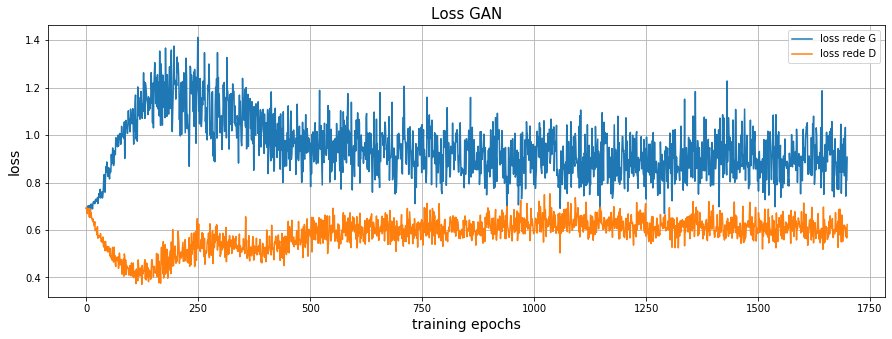

In [139]:
plt.figure(figsize=(15,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(ep), g_loss, label="loss rede G")
plt.plot(range(ep), d_loss, label="loss rede D")
plt.xlabel("training epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

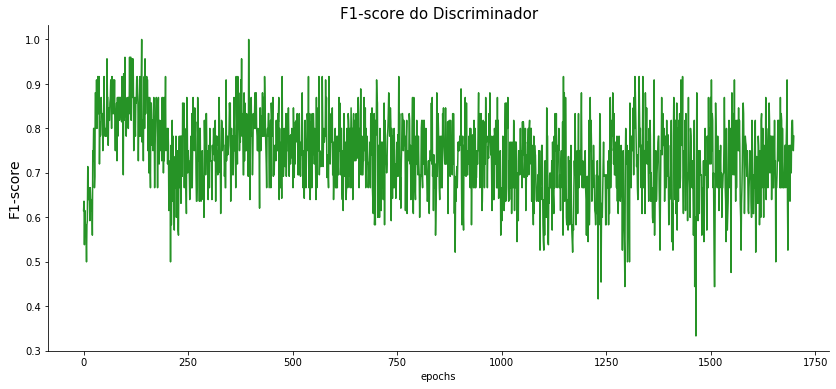

In [140]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("F1-score do Discriminador", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("F1-score", fontsize=14)
plt.plot(range(len(fscore)), fscore, color="green", alpha=.85);

(21, 2) (800, 2)


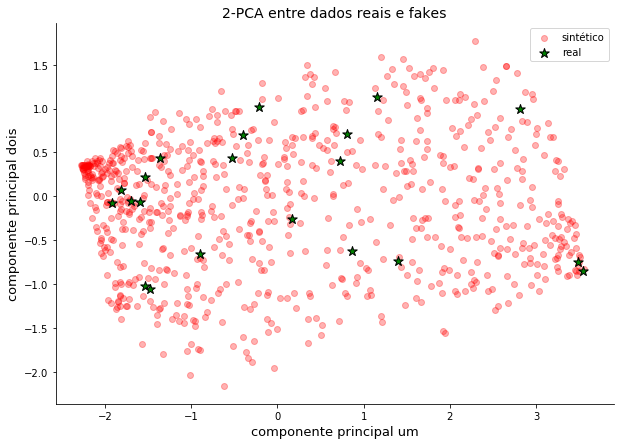

In [141]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(800,noise_input)))
X_fake_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_fake_pca.shape)
plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_fake_pca[:,0], X_fake_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();